# Ordinary Kriging - Synthetic Dataset (LR1)

## Importing packages and loading necessary datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipdw
from sklearn.model_selection import train_test_split, GridSearchCV, GroupKFold
from photutils.utils import ShepardIDWInterpolator
import time
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import skgstat as skg

In [2]:
import os

# Get the current working directory
current_dir = os.getcwd()

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

# Change to the parent directory
os.chdir(parent_dir)

# Print the new current working directory to confirm
print("Changed to:", os.getcwd())

Changed to: C:\Users\chloe\OneDrive\AY2024 FYP\FYP-Code\FYP-Spatial-Analytics


# 200 points calibration

In [3]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/LR1/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_LR1_input_randomfield_cal200.csv')
val_df = pd.read_csv(f'{file_path}val_LR1_input_randomfield_cal200.csv')
test_df = pd.read_csv(f'{file_path}test_LR1_input_randomfield_cal200.csv')

In [4]:
# Initialize an empty dictionary for storing scores
cv_score_list_200_model = {}
models_list = ['spherical', 'exponential', 'gaussian', 'matern', 'stable', 'cubic']

start_time = time.time()

# For each hyperparameter value
for model in models_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Fit Variogram
    V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = model)
    
    # Fit Ordinary Kriging model
    OK = skg.OrdinaryKriging(V_train, mode='exact')
    
    # Predict on the validation set
    z_pred_validation = OK.transform(val_df['x'], val_df['y'])
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    sigma = np.mean(OK.sigma)
    
    # Store the scores
    cv_score_list_200_model[model] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2,
        "Validation Score Kriging Var": sigma
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_200_model))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None},
    "Validation Score Kriging Var": {"value": float('inf'), "model": None}
}

for model, scores in  cv_score_list_200_model.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in model {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in model {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,spherical,exponential,gaussian,matern,stable,cubic
Validation Score MAE,0.455236,0.474488,0.442732,0.441405,0.446221,0.441624
Validation Score RMSE,0.577898,0.600630,0.561004,0.559311,0.565696,0.559388
Validation Score MAPE,1.686653,1.779750,1.530924,1.532689,1.535513,1.555028
Validation Score R Squared,0.694760,0.670275,0.712346,0.714080,0.707515,0.714001
Validation Score Kriging Var,0.192654,0.225839,0.237471,0.226010,0.265018,0.206404


The smallest Validation Score MAE is 0.44140546606657927, found in model matern.
The smallest Validation Score RMSE is 0.5593110730977092, found in model matern.
The smallest Validation Score MAPE is 1.5309235278393003, found in model gaussian.
The largest Validation Score R Squared is 0.7140798326257962, found in model matern.
The smallest Validation Score Kriging Var is 0.1926539836592805, found in model spherical.
Validation Computation Time: 6.11 seconds


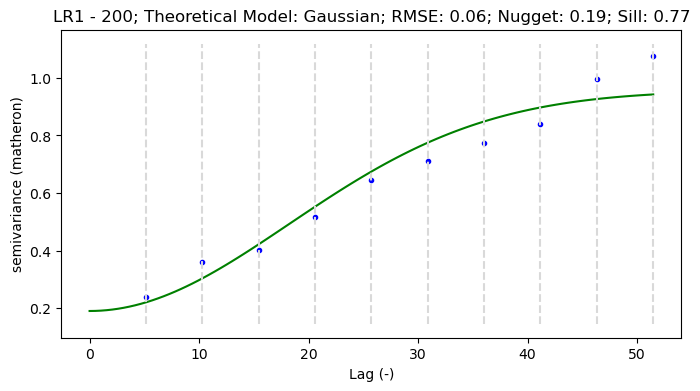

In [5]:
V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = 'gaussian')
fig = V_train.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'LR1 - 200; Theoretical Model: Gaussian; RMSE: {V_train.rmse:.2f}; Nugget: {V_train.describe()["nugget"]:.2f}; Sill: {V_train.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

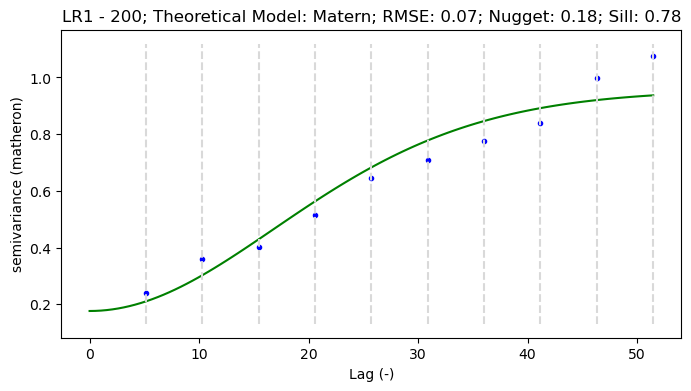

In [6]:
V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = 'matern')
fig = V_train.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'LR1 - 200; Theoretical Model: Matern; RMSE: {V_train.rmse:.2f}; Nugget: {V_train.describe()["nugget"]:.2f}; Sill: {V_train.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

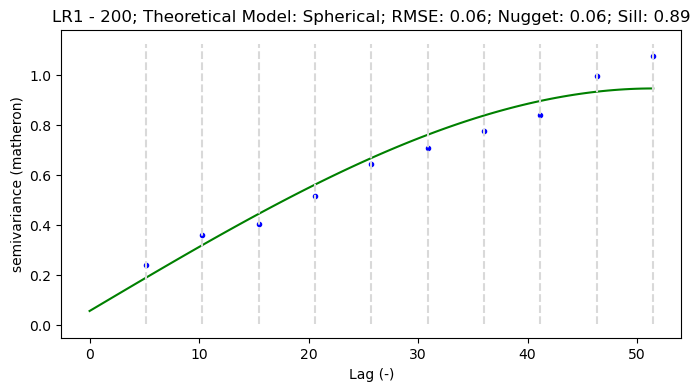

In [7]:
V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = 'spherical')
fig = V_train.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'LR1 - 200; Theoretical Model: Spherical; RMSE: {V_train.rmse:.2f}; Nugget: {V_train.describe()["nugget"]:.2f}; Sill: {V_train.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

# 400 points calibration

In [8]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/LR1/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_LR1_input_randomfield_cal400.csv')
val_df = pd.read_csv(f'{file_path}val_LR1_input_randomfield_cal400.csv')
test_df = pd.read_csv(f'{file_path}test_LR1_input_randomfield_cal400.csv')

In [9]:
# Initialize an empty dictionary for storing scores
cv_score_list_400_model = {}
models_list = ['spherical', 'exponential', 'gaussian', 'matern', 'stable', 'cubic']

start_time = time.time()

# For each hyperparameter value
for model in models_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Fit Variogram
    V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = model)
    
    # Fit Ordinary Kriging model
    OK = skg.OrdinaryKriging(V_train, mode='exact')
    
    # Predict on the validation set
    z_pred_validation = OK.transform(val_df['x'], val_df['y'])
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    sigma = np.mean(OK.sigma)
    
    # Store the scores
    cv_score_list_400_model[model] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2,
        "Validation Score Kriging Var": sigma
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_400_model))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None},
    "Validation Score Kriging Var": {"value": float('inf'), "model": None}
}

for model, scores in  cv_score_list_400_model.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in model {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in model {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")

,spherical,exponential,gaussian,matern,stable,cubic
Validation Score MAE,0.444307,0.481611,0.430702,0.429834,0.432481,0.429845
Validation Score RMSE,0.565321,0.607561,0.547897,0.547157,0.549576,0.547734
Validation Score MAPE,1.595659,1.796054,1.553519,1.550385,1.572272,1.552505
Validation Score R Squared,0.707903,0.662621,0.725630,0.726372,0.723946,0.725794
Validation Score Kriging Var,0.200533,0.167858,0.258379,0.245654,0.290871,0.219796


The smallest Validation Score MAE is 0.42983400553007683, found in model matern.
The smallest Validation Score RMSE is 0.5471565682589039, found in model matern.
The smallest Validation Score MAPE is 1.550384861543092, found in model matern.
The largest Validation Score R Squared is 0.7263715889714054, found in model matern.
The smallest Validation Score Kriging Var is 0.1678581027207352, found in model exponential.
Validation Computation Time: 4.36 seconds


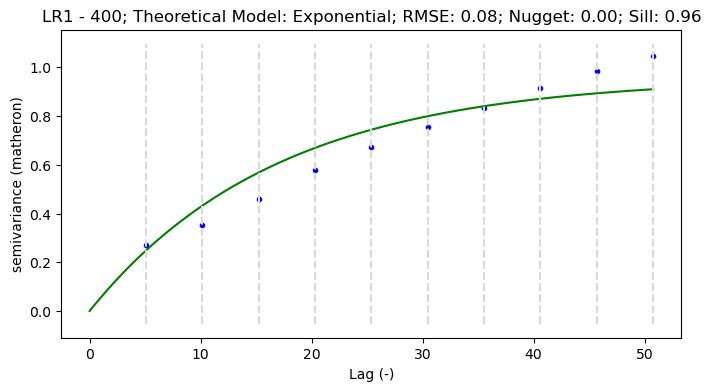

In [13]:
V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = 'exponential')
fig = V_train.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'LR1 - 400; Theoretical Model: Exponential; RMSE: {V_train.rmse:.2f}; Nugget: {V_train.describe()["nugget"]:.2f}; Sill: {V_train.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

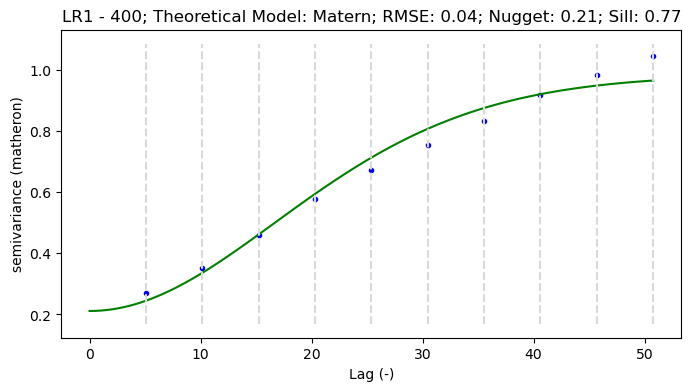

In [12]:
V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = 'matern')
fig = V_train.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'LR1 - 400; Theoretical Model: Matern; RMSE: {V_train.rmse:.2f}; Nugget: {V_train.describe()["nugget"]:.2f}; Sill: {V_train.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

# 600 points calibration

In [14]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/LR1/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_LR1_input_randomfield_cal600.csv')
val_df = pd.read_csv(f'{file_path}val_LR1_input_randomfield_cal600.csv')
test_df = pd.read_csv(f'{file_path}test_LR1_input_randomfield_cal600.csv')

In [15]:
# Initialize an empty dictionary for storing scores
cv_score_list_600_model = {}
models_list = ['spherical', 'exponential', 'gaussian', 'matern', 'stable', 'cubic']

start_time = time.time()

# For each hyperparameter value
for model in models_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Fit Variogram
    V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = model)
    
    # Fit Ordinary Kriging model
    OK = skg.OrdinaryKriging(V_train, mode='exact')
    
    # Predict on the validation set
    z_pred_validation = OK.transform(val_df['x'], val_df['y'])
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    sigma = np.mean(OK.sigma)
    
    # Store the scores
    cv_score_list_600_model[model] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2,
        "Validation Score Kriging Var": sigma
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_600_model))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None},
    "Validation Score Kriging Var": {"value": float('inf'), "model": None}
}

for model, scores in  cv_score_list_600_model.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in model {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in model {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,spherical,exponential,gaussian,matern,stable,cubic
Validation Score MAE,0.440627,0.473943,0.418711,0.418140,0.420204,0.418402
Validation Score RMSE,0.560489,0.600569,0.529876,0.529388,0.531355,0.530491
Validation Score MAPE,1.578304,1.743555,1.547661,1.537140,1.565407,1.512848
Validation Score R Squared,0.712874,0.670342,0.743382,0.743855,0.741948,0.742787
Validation Score Kriging Var,0.147963,0.142993,0.226483,0.211707,0.264186,0.180814


The smallest Validation Score MAE is 0.41814044419532287, found in model matern.
The smallest Validation Score RMSE is 0.5293880729250352, found in model matern.
The smallest Validation Score MAPE is 1.5128483051501984, found in model cubic.
The largest Validation Score R Squared is 0.7438547778915918, found in model matern.
The smallest Validation Score Kriging Var is 0.1429932900035355, found in model exponential.
Validation Computation Time: 4.65 seconds


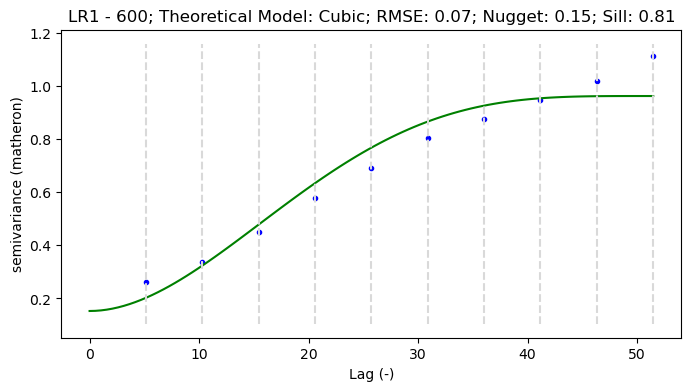

In [16]:
V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = 'cubic')
fig = V_train.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'LR1 - 600; Theoretical Model: Cubic; RMSE: {V_train.rmse:.2f}; Nugget: {V_train.describe()["nugget"]:.2f}; Sill: {V_train.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

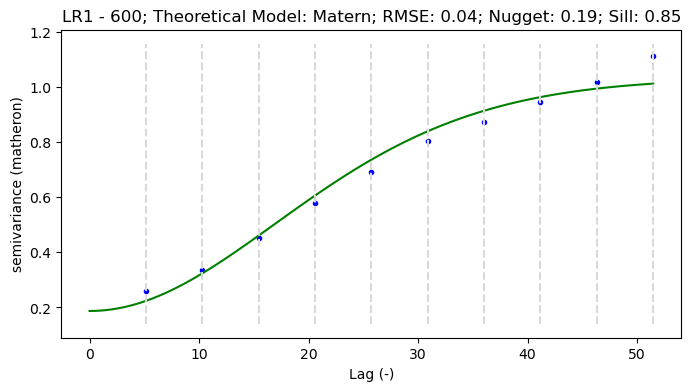

In [17]:
V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = 'matern')
fig = V_train.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'LR1 - 600; Theoretical Model: Matern; RMSE: {V_train.rmse:.2f}; Nugget: {V_train.describe()["nugget"]:.2f}; Sill: {V_train.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

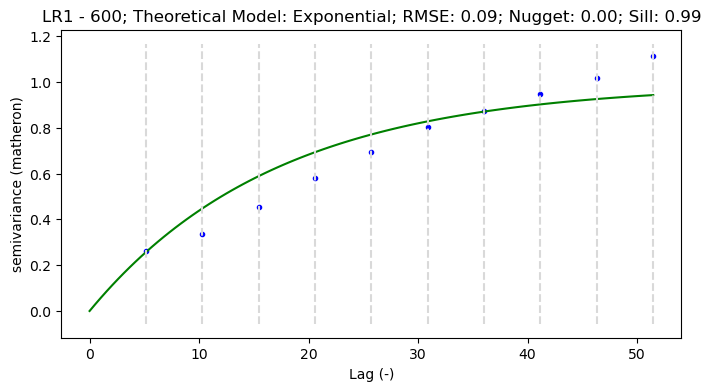

In [18]:
V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = 'exponential')
fig = V_train.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'LR1 - 600; Theoretical Model: Exponential; RMSE: {V_train.rmse:.2f}; Nugget: {V_train.describe()["nugget"]:.2f}; Sill: {V_train.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

# 800 points calibration

In [19]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/LR1/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_LR1_input_randomfield_cal800.csv')
val_df = pd.read_csv(f'{file_path}val_LR1_input_randomfield_cal800.csv')
test_df = pd.read_csv(f'{file_path}test_LR1_input_randomfield_cal800.csv')

In [20]:
# Initialize an empty dictionary for storing scores
cv_score_list_800_model = {}
models_list = ['spherical', 'exponential', 'gaussian', 'matern', 'stable', 'cubic']

start_time = time.time()

# For each hyperparameter value
for model in models_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Fit Variogram
    V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = model)
    
    # Fit Ordinary Kriging model
    OK = skg.OrdinaryKriging(V_train, mode='exact')
    
    # Predict on the validation set
    z_pred_validation = OK.transform(val_df['x'], val_df['y'])
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    sigma = np.mean(OK.sigma)
    
    # Store the scores
    cv_score_list_800_model[model] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2,
        "Validation Score Kriging Var": sigma
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_800_model))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None},
    "Validation Score Kriging Var": {"value": float('inf'), "model": None}
}

for model, scores in  cv_score_list_800_model.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in model {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in model {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,spherical,exponential,gaussian,matern,stable,cubic
Validation Score MAE,0.445352,0.480094,0.417518,0.417188,0.418326,0.417760
Validation Score RMSE,0.565792,0.608896,0.526680,0.526471,0.527429,0.527927
Validation Score MAPE,1.730730,1.903261,1.573046,1.576237,1.567760,1.590340
Validation Score R Squared,0.707416,0.661137,0.746469,0.746670,0.745747,0.745266
Validation Score Kriging Var,0.132907,0.129204,0.223097,0.207732,0.260903,0.176633


The smallest Validation Score MAE is 0.41718837662304314, found in model matern.
The smallest Validation Score RMSE is 0.5264709596100912, found in model matern.
The smallest Validation Score MAPE is 1.567759872489718, found in model stable.
The largest Validation Score R Squared is 0.7466698997151512, found in model matern.
The smallest Validation Score Kriging Var is 0.12920413346660425, found in model exponential.
Validation Computation Time: 4.91 seconds


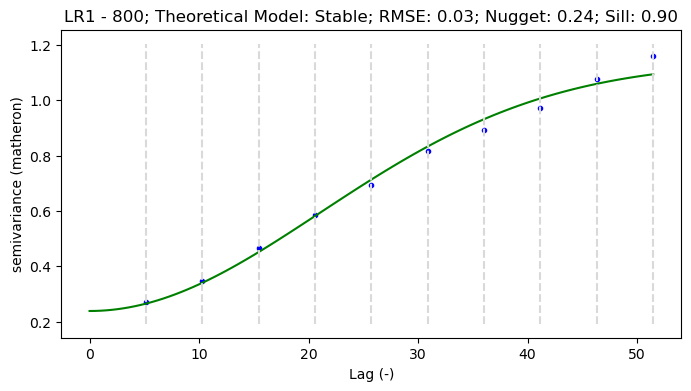

In [21]:
V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = 'stable')
fig = V_train.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'LR1 - 800; Theoretical Model: Stable; RMSE: {V_train.rmse:.2f}; Nugget: {V_train.describe()["nugget"]:.2f}; Sill: {V_train.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

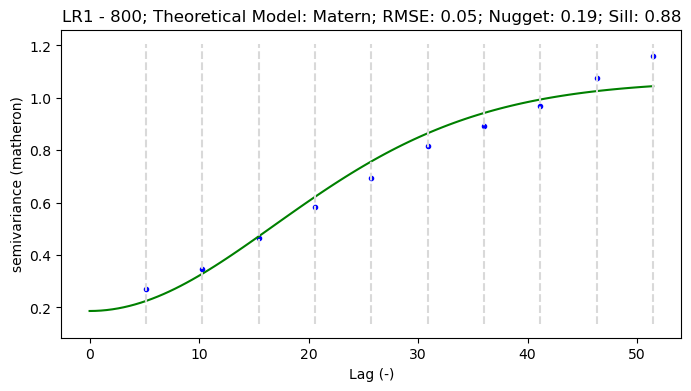

In [22]:
V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = 'matern')
fig = V_train.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'LR1 - 800; Theoretical Model: Matern; RMSE: {V_train.rmse:.2f}; Nugget: {V_train.describe()["nugget"]:.2f}; Sill: {V_train.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

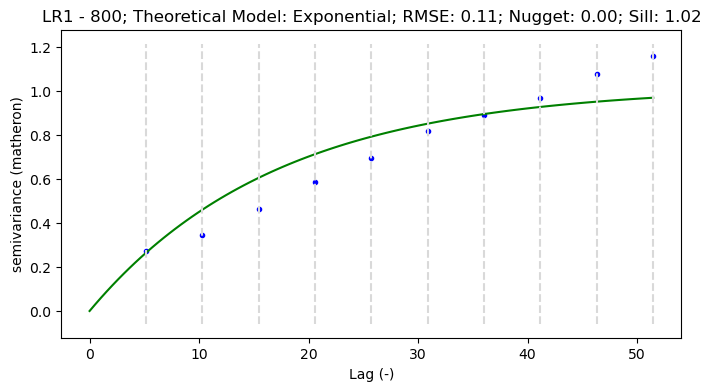

In [23]:
V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = 'exponential')
fig = V_train.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'LR1 - 800; Theoretical Model: Exponential; RMSE: {V_train.rmse:.2f}; Nugget: {V_train.describe()["nugget"]:.2f}; Sill: {V_train.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

# 1000 points calibration

In [24]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/LR1/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_LR1_input_randomfield_cal1000.csv')
val_df = pd.read_csv(f'{file_path}val_LR1_input_randomfield_cal1000.csv')
test_df = pd.read_csv(f'{file_path}test_LR1_input_randomfield_cal1000.csv')

In [25]:
# Initialize an empty dictionary for storing scores
cv_score_list_1000_model = {}
models_list = ['spherical', 'exponential', 'gaussian', 'matern', 'stable', 'cubic']

start_time = time.time()

# For each hyperparameter value
for model in models_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Fit Variogram
    V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = model)
    
    # Fit Ordinary Kriging model
    OK = skg.OrdinaryKriging(V_train, mode='exact')
    
    # Predict on the validation set
    z_pred_validation = OK.transform(val_df['x'], val_df['y'])
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    sigma = np.mean(OK.sigma)
    
    # Store the scores
    cv_score_list_1000_model[model] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2,
        "Validation Score Kriging Var": sigma
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_1000_model))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None},
    "Validation Score Kriging Var": {"value": float('inf'), "model": None}
}

for model, scores in  cv_score_list_1000_model.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in model {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in model {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")

,spherical,exponential,gaussian,matern,stable,cubic
Validation Score MAE,0.439606,0.477654,0.414424,0.414291,0.414801,0.414880
Validation Score RMSE,0.560117,0.607345,0.525313,0.525240,0.525703,0.526294
Validation Score MAPE,1.774207,1.962209,1.602879,1.608861,1.595341,1.633014
Validation Score R Squared,0.713255,0.662862,0.747783,0.747853,0.747409,0.746840
Validation Score Kriging Var,0.127846,0.113770,0.221823,0.206411,0.259026,0.175435


The smallest Validation Score MAE is 0.4142914203865258, found in model matern.
The smallest Validation Score RMSE is 0.5252402518093162, found in model matern.
The smallest Validation Score MAPE is 1.5953411025364692, found in model stable.
The largest Validation Score R Squared is 0.7478529124273603, found in model matern.
The smallest Validation Score Kriging Var is 0.1137695554396937, found in model exponential.
Validation Computation Time: 5.21 seconds


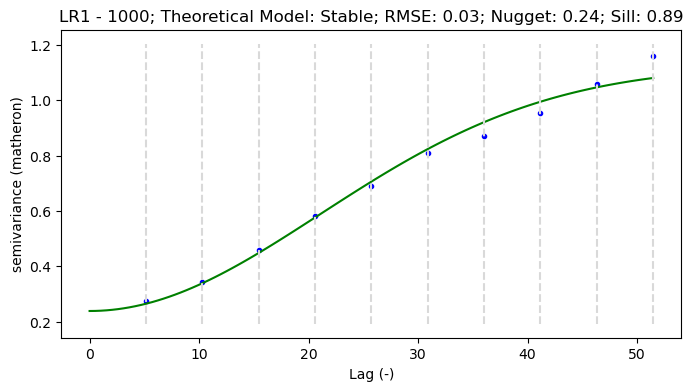

In [26]:
V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = 'stable')
fig = V_train.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'LR1 - 1000; Theoretical Model: Stable; RMSE: {V_train.rmse:.2f}; Nugget: {V_train.describe()["nugget"]:.2f}; Sill: {V_train.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

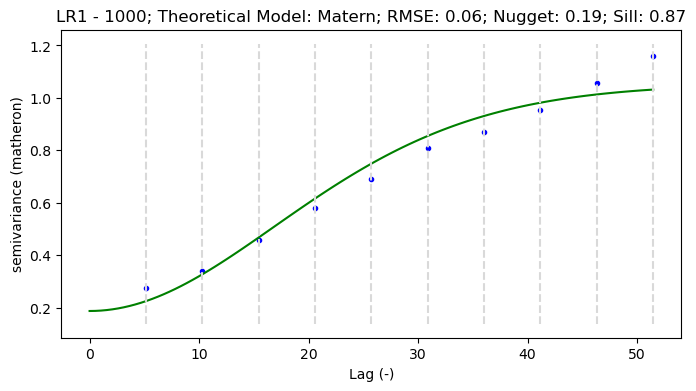

In [27]:
V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = 'matern')
fig = V_train.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'LR1 - 1000; Theoretical Model: Matern; RMSE: {V_train.rmse:.2f}; Nugget: {V_train.describe()["nugget"]:.2f}; Sill: {V_train.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

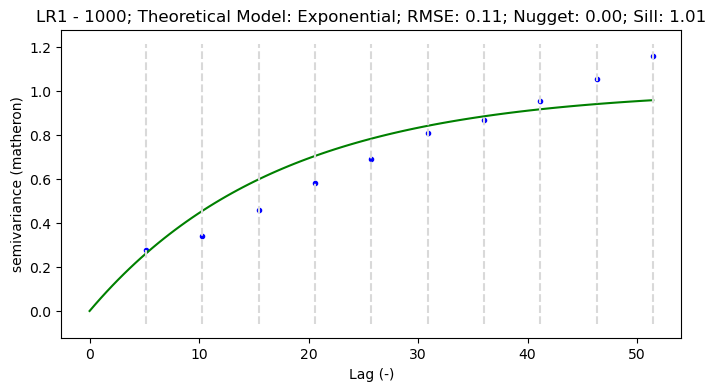

In [28]:
V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = 'exponential')
fig = V_train.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'LR1 - 1000; Theoretical Model: Exponential; RMSE: {V_train.rmse:.2f}; Nugget: {V_train.describe()["nugget"]:.2f}; Sill: {V_train.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

# 1500 points calibration

In [29]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/LR1/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_LR1_input_randomfield_cal1500.csv')
val_df = pd.read_csv(f'{file_path}val_LR1_input_randomfield_cal1500.csv')
test_df = pd.read_csv(f'{file_path}test_LR1_input_randomfield_cal1500.csv')

In [30]:
# Initialize an empty dictionary for storing scores
cv_score_list_1500_model = {}
models_list = ['spherical', 'exponential', 'gaussian', 'matern', 'stable', 'cubic']

start_time = time.time()

# For each hyperparameter value
for model in models_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Fit Variogram
    V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = model)
    
    # Fit Ordinary Kriging model
    OK = skg.OrdinaryKriging(V_train, mode='exact')
    
    # Predict on the validation set
    z_pred_validation = OK.transform(val_df['x'], val_df['y'])
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    sigma = np.mean(OK.sigma)
    
    # Store the scores
    cv_score_list_1500_model[model] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2,
        "Validation Score Kriging Var": sigma
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_1500_model))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None},
    "Validation Score Kriging Var": {"value": float('inf'), "model": None}
}

for model, scores in  cv_score_list_1500_model.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in model {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in model {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,spherical,exponential,gaussian,matern,stable,cubic
Validation Score MAE,0.442125,0.475943,0.414181,0.414167,0.414436,0.414680
Validation Score RMSE,0.558189,0.600141,0.523755,0.523833,0.523707,0.524452
Validation Score MAPE,1.818036,1.853547,1.654004,1.658440,1.649429,1.680648
Validation Score R Squared,0.715226,0.670812,0.749277,0.749202,0.749323,0.748610
Validation Score Kriging Var,0.102702,0.094955,0.208990,0.192998,0.245803,0.161513


The smallest Validation Score MAE is 0.41416650738787586, found in model matern.
The smallest Validation Score RMSE is 0.5237065333534839, found in model stable.
The smallest Validation Score MAPE is 1.6494287757332586, found in model stable.
The largest Validation Score R Squared is 0.749323317710193, found in model stable.
The smallest Validation Score Kriging Var is 0.0949545711717323, found in model exponential.
Validation Computation Time: 6.65 seconds


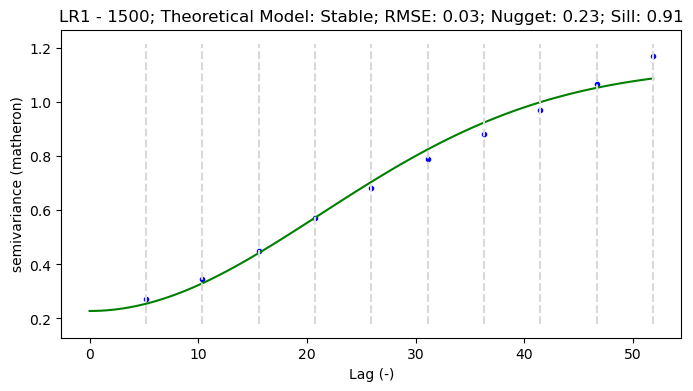

In [31]:
V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = 'stable')
fig = V_train.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'LR1 - 1500; Theoretical Model: Stable; RMSE: {V_train.rmse:.2f}; Nugget: {V_train.describe()["nugget"]:.2f}; Sill: {V_train.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

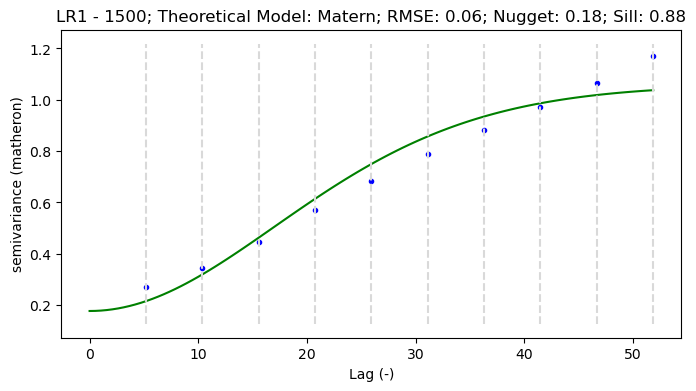

In [32]:
V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = 'matern')
fig = V_train.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'LR1 - 1500; Theoretical Model: Matern; RMSE: {V_train.rmse:.2f}; Nugget: {V_train.describe()["nugget"]:.2f}; Sill: {V_train.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

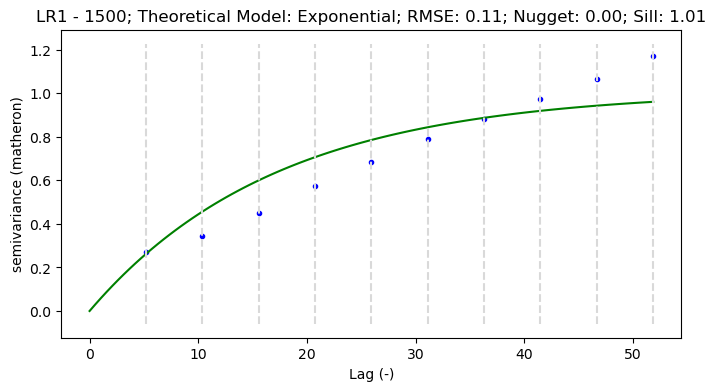

In [33]:
V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = 'exponential')
fig = V_train.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'LR1 - 1500; Theoretical Model: Exponential; RMSE: {V_train.rmse:.2f}; Nugget: {V_train.describe()["nugget"]:.2f}; Sill: {V_train.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

# 2000 points calibration

In [34]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/LR1/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_LR1_input_randomfield_cal2000.csv')
val_df = pd.read_csv(f'{file_path}val_LR1_input_randomfield_cal2000.csv')
test_df = pd.read_csv(f'{file_path}test_LR1_input_randomfield_cal2000.csv')

In [35]:
# Initialize an empty dictionary for storing scores
cv_score_list_2000_model = {}
models_list = ['spherical', 'exponential', 'gaussian', 'matern', 'stable', 'cubic']

start_time = time.time()

# For each hyperparameter value
for model in models_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Fit Variogram
    V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = model)
    
    # Fit Ordinary Kriging model
    OK = skg.OrdinaryKriging(V_train, mode='exact')
    
    # Predict on the validation set
    z_pred_validation = OK.transform(val_df['x'], val_df['y'])
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    sigma = np.mean(OK.sigma)
    
    # Store the scores
    cv_score_list_2000_model[model] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2,
        "Validation Score Kriging Var": sigma
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_2000_model))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None},
    "Validation Score Kriging Var": {"value": float('inf'), "model": None}
}

for model, scores in  cv_score_list_2000_model.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in model {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in model {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,spherical,exponential,gaussian,matern,stable,cubic
Validation Score MAE,0.435180,0.468419,0.408851,0.408779,0.409105,0.409049
Validation Score RMSE,0.550035,0.591880,0.516595,0.516625,0.516618,0.517013
Validation Score MAPE,1.662781,1.686255,1.612590,1.616119,1.608560,1.630402
Validation Score R Squared,0.723485,0.679812,0.756085,0.756057,0.756063,0.755690
Validation Score Kriging Var,0.091975,0.082942,0.203107,0.187072,0.240475,0.154455


The smallest Validation Score MAE is 0.40877883751868593, found in model matern.
The smallest Validation Score RMSE is 0.5165954174603763, found in model gaussian.
The smallest Validation Score MAPE is 1.608560299201676, found in model stable.
The largest Validation Score R Squared is 0.756084694274323, found in model gaussian.
The smallest Validation Score Kriging Var is 0.08294209915398812, found in model exponential.
Validation Computation Time: 8.37 seconds


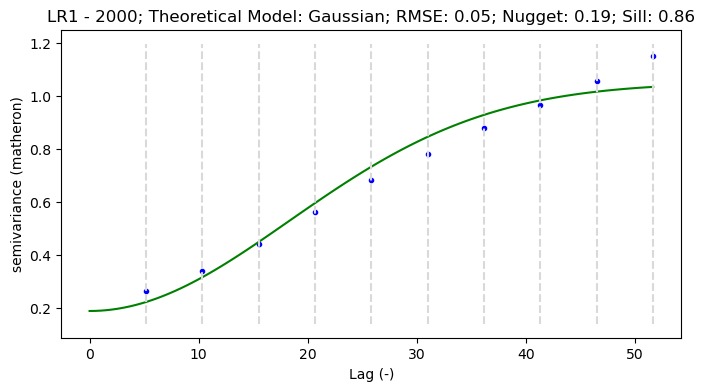

In [36]:
V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = 'gaussian')
fig = V_train.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'LR1 - 2000; Theoretical Model: Gaussian; RMSE: {V_train.rmse:.2f}; Nugget: {V_train.describe()["nugget"]:.2f}; Sill: {V_train.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

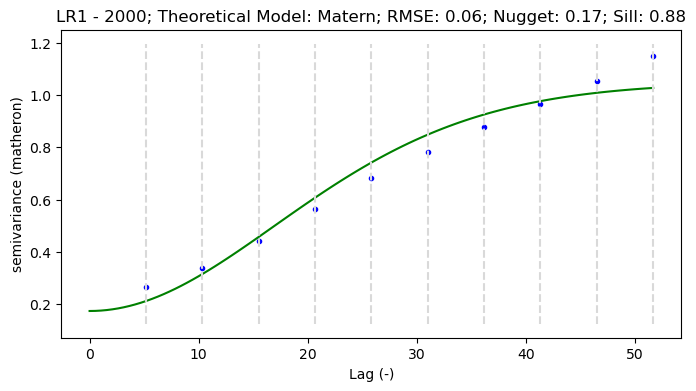

In [37]:
V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = 'matern')
fig = V_train.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'LR1 - 2000; Theoretical Model: Matern; RMSE: {V_train.rmse:.2f}; Nugget: {V_train.describe()["nugget"]:.2f}; Sill: {V_train.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

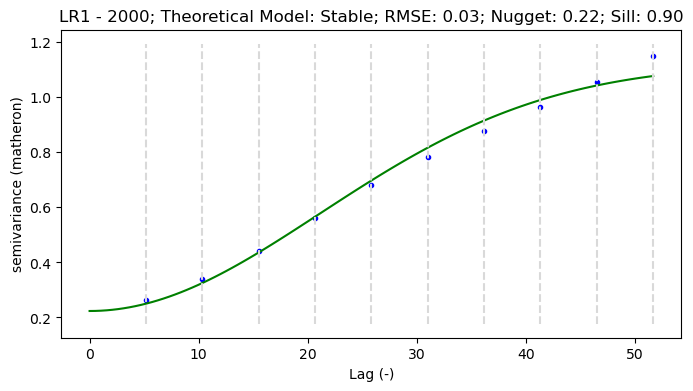

In [38]:
V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = 'stable')
fig = V_train.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'LR1 - 2000; Theoretical Model: Stable; RMSE: {V_train.rmse:.2f}; Nugget: {V_train.describe()["nugget"]:.2f}; Sill: {V_train.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

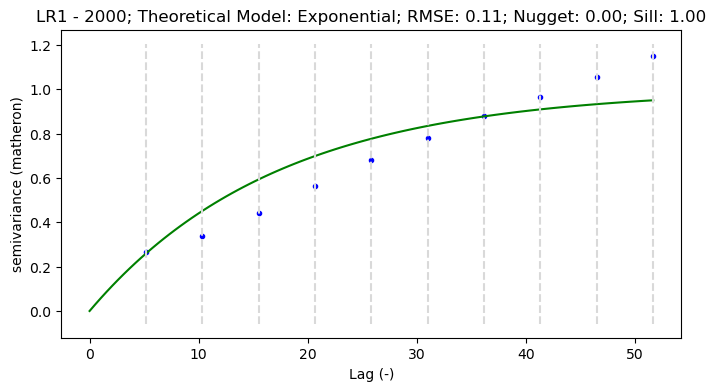

In [39]:
V_train = skg.Variogram(combined_array_train, cal_df['z'], maxlag='median', use_nugget = True, fit_method = 'ml', model = 'exponential')
fig = V_train.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'LR1 - 2000; Theoretical Model: Exponential; RMSE: {V_train.rmse:.2f}; Nugget: {V_train.describe()["nugget"]:.2f}; Sill: {V_train.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

## Validation score as calibration set size increases

In [40]:
def calculate_means(data_structures):
    all_means = {}
    for structure_id, data in enumerate(data_structures, 1):
        means = {key: sum(d[key] for d in data.values()) / len(data) for key in data[next(iter(data))]}
        all_means[f"Structure {structure_id}"] = means
    return all_means

# List of data structures
data_structures_model = [cv_score_list_200_model, cv_score_list_400_model, cv_score_list_600_model, cv_score_list_800_model,cv_score_list_1000_model,cv_score_list_1500_model, cv_score_list_2000_model]

# Calculate means
all_means_model = calculate_means(data_structures_model)

In [41]:
new_keys = [200, 400, 600, 800, 1000, 1500, 2000]

# Function to replace keys
def replace_keys(structures, new_keys):
    # Make sure there are enough new keys for the structures
    if len(new_keys) < len(structures):
        raise ValueError("Not enough new keys for the number of structures")

    # New dictionary to store replaced key structures
    replaced_structures = {}

    # Use zip to iterate over both the items in structures and the new_keys simultaneously
    for new_key, (old_key, value) in zip(new_keys, structures.items()):
        replaced_structures[new_key] = value

    return replaced_structures

all_means_model = replace_keys(all_means_model, new_keys)

In [42]:
cal_size = [200, 400, 600, 800, 1000, 1500, 2000]
all_means_model_df = pd.DataFrame(all_means_model).T
all_means_model_df
#Mean validation score across all theoratical models for differing calibration set sizes

,Validation Score MAE,Validation Score RMSE,Validation Score MAPE,Validation Score R Squared,Validation Score Kriging Var
200,0.450284,0.570655,1.603426,0.702163,0.225566
400,0.441463,0.560874,1.603399,0.712044,0.230515
600,0.431671,0.547028,1.580819,0.725865,0.195691
800,0.432706,0.547199,1.656896,0.725451,0.188413
1000,0.429276,0.545002,1.696085,0.727667,0.184052
1500,0.429255,0.542346,1.719017,0.730408,0.167827
2000,0.423230,0.534794,1.636118,0.737865,0.160004


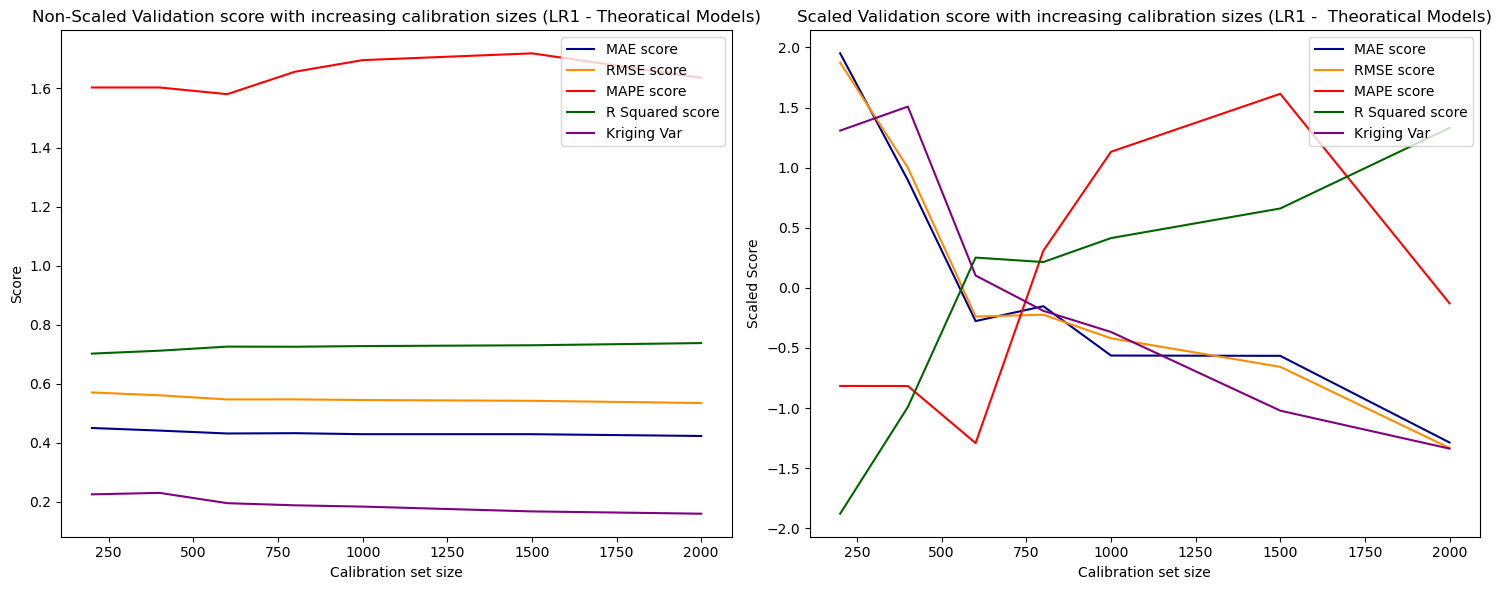

In [44]:
# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(all_means_model_df), columns=all_means_model_df.columns, index=all_means_model_df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(cal_size, all_means_model_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(cal_size, all_means_model_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(cal_size, all_means_model_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(cal_size, all_means_model_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].plot(cal_size, all_means_model_df["Validation Score Kriging Var"], color='purple', label='Kriging Var')
ax[0].set_xlabel('Calibration set size')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation score with increasing calibration sizes (LR1 - Theoratical Models)")

# Plot normalized data on the second subplot
ax[1].plot(cal_size, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(cal_size, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(cal_size, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(cal_size, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].plot(cal_size, normalized_df["Validation Score Kriging Var"], color='purple', label='Kriging Var')
ax[1].set_xlabel('Calibration set size')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation score with increasing calibration sizes (LR1 -  Theoratical Models)")

plt.tight_layout()
plt.show()

# Trend of each performance metric for each type of theoratical model as calibration set size increases

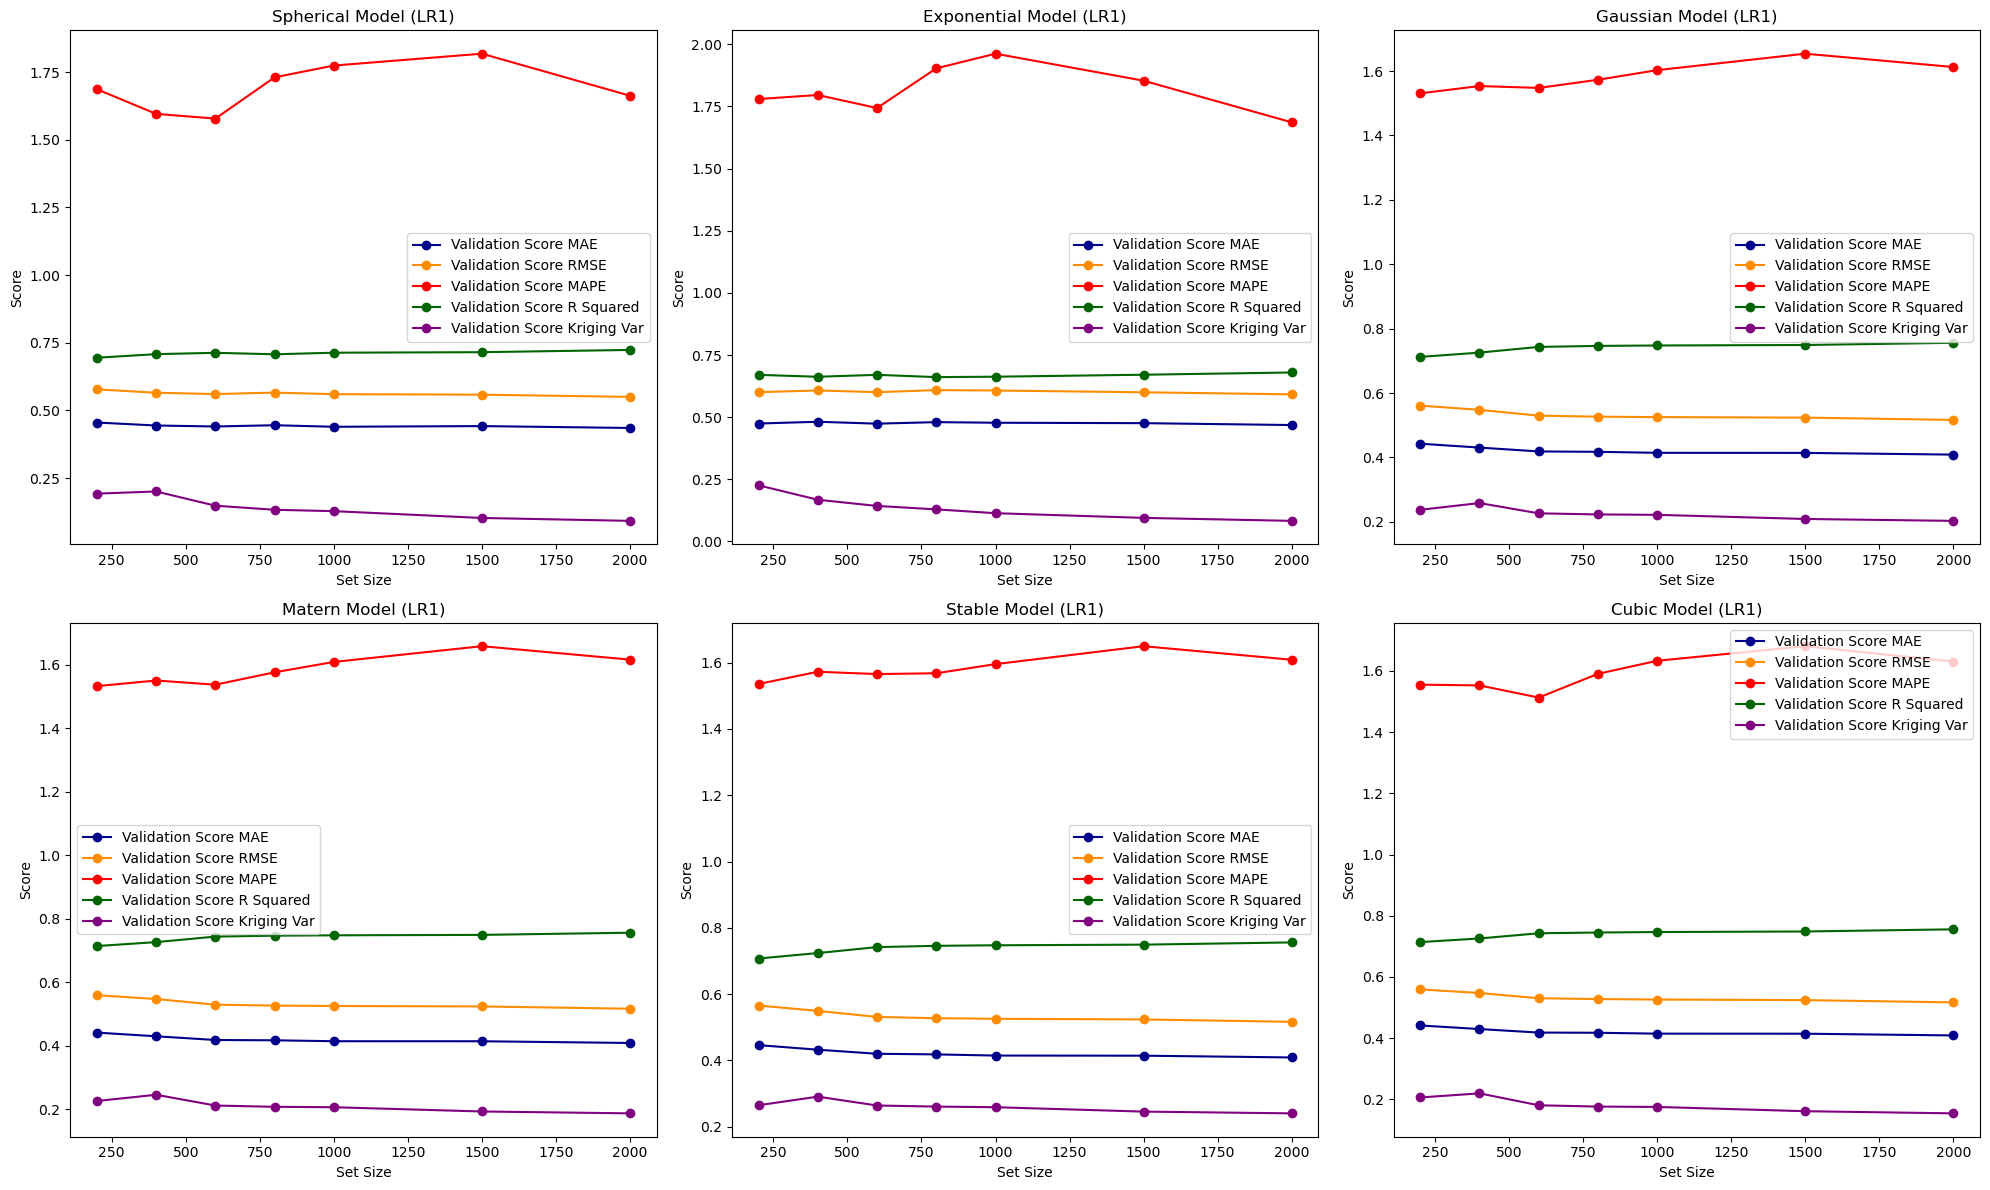

In [45]:
data_structures = {
    '200': cv_score_list_200_model,
    '400': cv_score_list_400_model,
    '600': cv_score_list_600_model,
    '800': cv_score_list_800_model,
    '1000': cv_score_list_1000_model,
    '1500': cv_score_list_1500_model,
    '2000': cv_score_list_2000_model
}

# Assuming a hypothetical structure for illustration
models = ['spherical', 'exponential', 'gaussian', 'matern', 'stable', 'cubic']
validation_scores = ['Validation Score MAE', 'Validation Score RMSE', 'Validation Score MAPE', 'Validation Score R Squared', 'Validation Score Kriging Var']
colors = ['darkblue', 'darkorange', 'red', 'darkgreen', 'purple']

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))
axs = axs.flatten()

set_sizes = [int(size) for size in data_structures.keys()]  # Extracting set sizes from the keys

for idx, model in enumerate(models):
    for score, color in zip(validation_scores, colors):
        scores = [data_structures[str(set_size)][model][score] for set_size in set_sizes]  # Extract scores for each set size
        
        # Plot on the corresponding subplot
        axs[idx].plot(set_sizes, scores, label=score, color=color, marker='o')  # Added markers for clarity

    axs[idx].set_title(f'{model.capitalize()} Model (LR1)')
    axs[idx].set_xlabel('Set Size')
    axs[idx].set_ylabel('Score')
    axs[idx].legend()

plt.tight_layout()
plt.show()

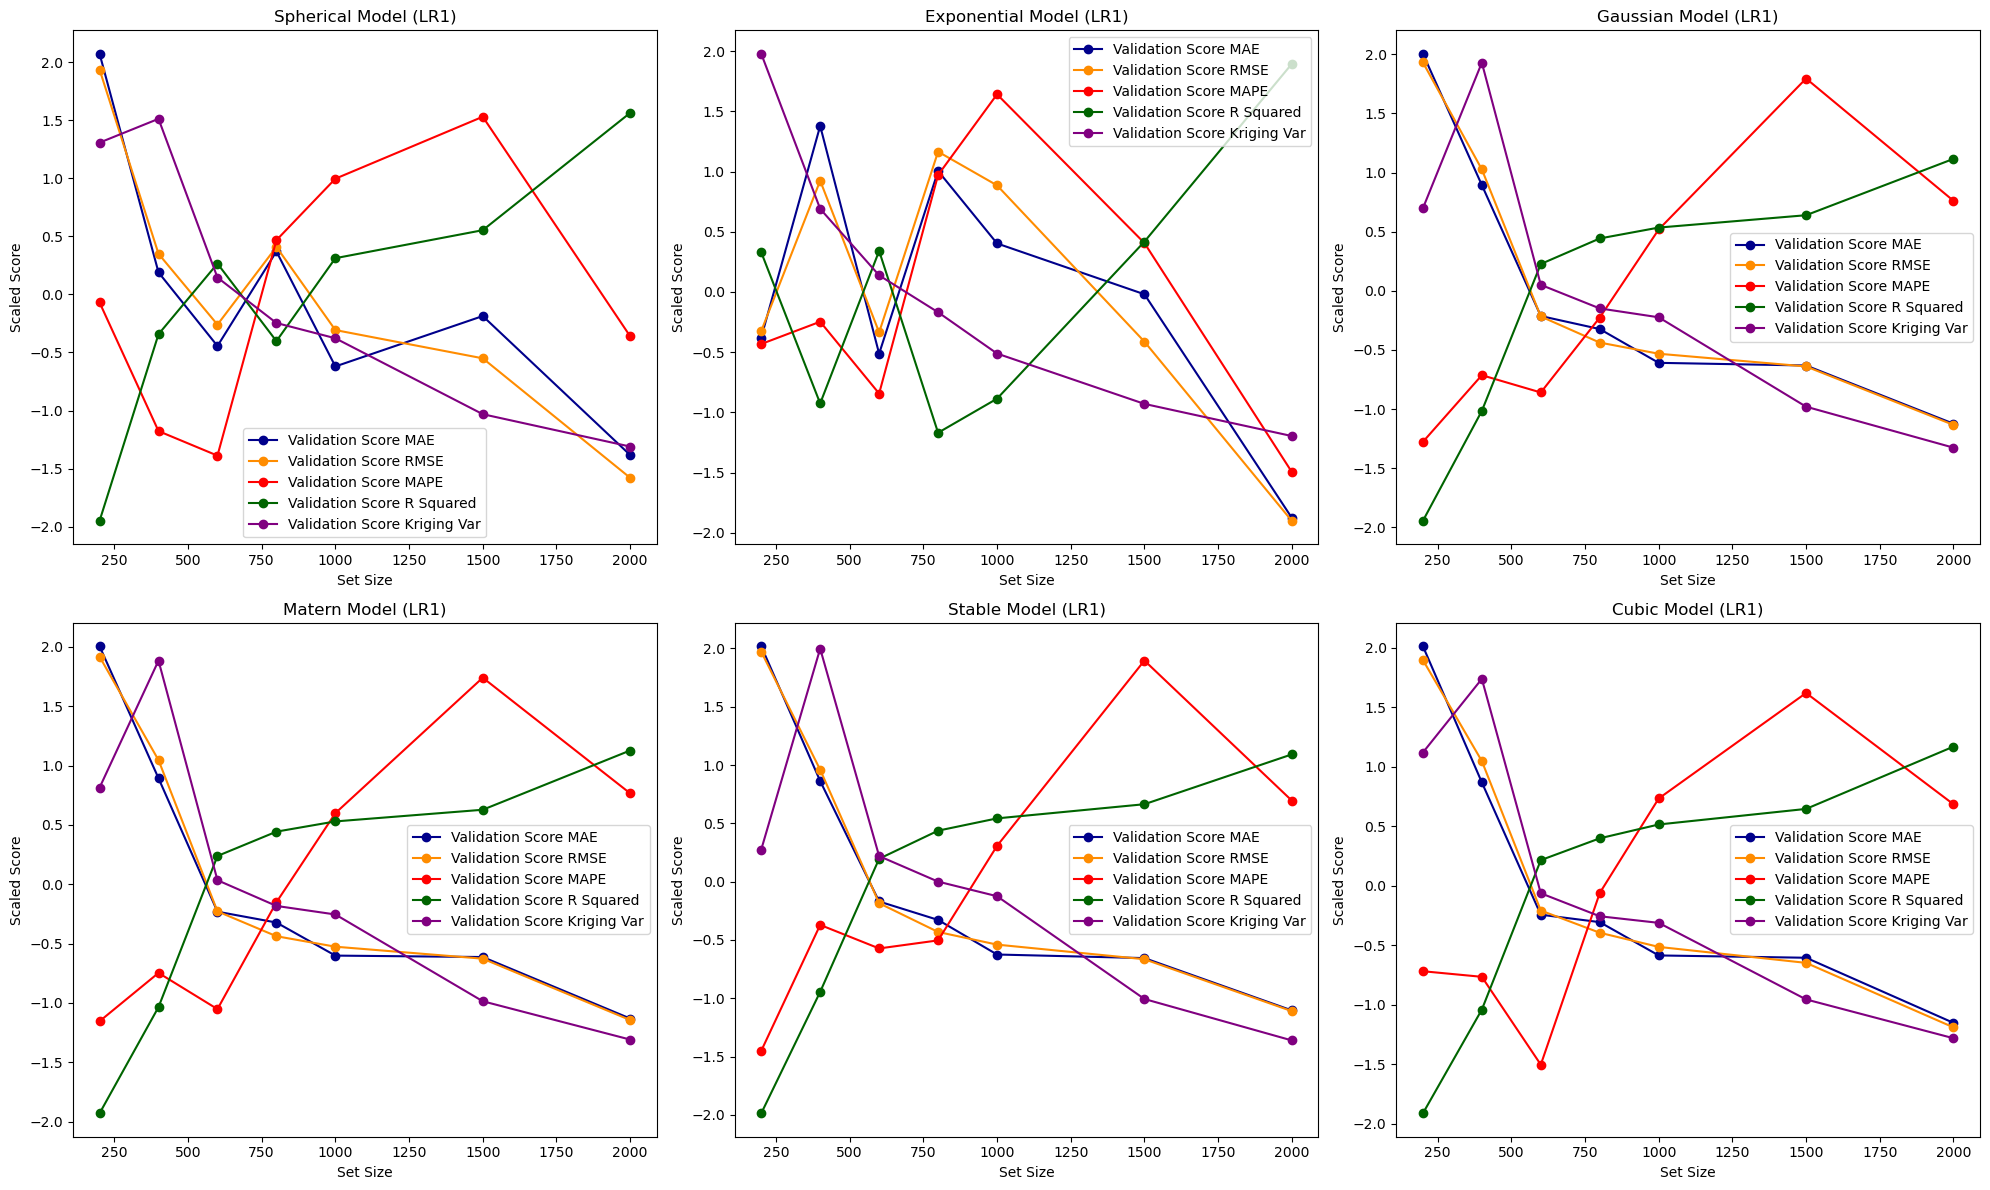

In [46]:
data_structures = {
    '200': cv_score_list_200_model,
    '400': cv_score_list_400_model,
    '600': cv_score_list_600_model,
    '800': cv_score_list_800_model,
    '1000': cv_score_list_1000_model,
    '1500': cv_score_list_1500_model,
    '2000': cv_score_list_2000_model
}

models = ['spherical', 'exponential', 'gaussian', 'matern', 'stable', 'cubic']
validation_scores = ['Validation Score MAE', 'Validation Score RMSE', 'Validation Score MAPE', 'Validation Score R Squared', 'Validation Score Kriging Var']
colors = ['darkblue', 'darkorange', 'red', 'darkgreen', 'purple']

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))
axs = axs.flatten()

set_sizes = [int(size) for size in data_structures.keys()]  # Extracting set sizes from the keys

scaler = StandardScaler()

for idx, model in enumerate(models):
    # Preparing an array for each score type to fit and transform with StandardScaler
    for score_type, color in zip(validation_scores, colors):
        # Extract scores for each set size and model
        scores_array = np.array([data_structures[str(set_size)][model][score_type] for set_size in set_sizes]).reshape(-1, 1)
        scaled_scores = scaler.fit_transform(scores_array).flatten()  # Scale and convert back to 1D array
        
        axs[idx].plot(set_sizes, scaled_scores, label=score_type, color=color, marker='o')

    axs[idx].set_title(f'{model.capitalize()} Model (LR1)')
    axs[idx].set_xlabel('Set Size')
    axs[idx].set_ylabel('Scaled Score')
    axs[idx].legend()

plt.tight_layout()
plt.show()

## Testing model (Final Performance Metrics)

In [47]:
filenames = ['LR1_input_randomfield_cal200','LR1_input_randomfield_cal400', 'LR1_input_randomfield_cal600',
             'LR1_input_randomfield_cal800', 'LR1_input_randomfield_cal1000', 'LR1_input_randomfield_cal1500', 'LR1_input_randomfield_cal2000']
#cal_SR0_input_randomfield_cal2000.csv
combined_df = pd.DataFrame()
for file in filenames:
    cal_df = pd.read_csv(f'Synthetic Data/LR1/cal_{file}.csv')
    combined_df = pd.concat([cal_df, combined_df], ignore_index=True)

combined_df = pd.concat([val_df, combined_df], ignore_index=True)
combined_df = combined_df.drop_duplicates() #The calibration sets are subsets of one another, hence needed

combined_df #All calibration points and validation data points

,x,y,z
0,39,4,-3.592163
1,47,42,-0.513731
2,92,88,-2.327298
3,24,43,-1.637715
4,37,92,-0.105953
...,...,...,...
3995,93,12,0.950197
3996,56,25,0.184283
3997,22,8,-2.189497
3998,38,35,-1.386126


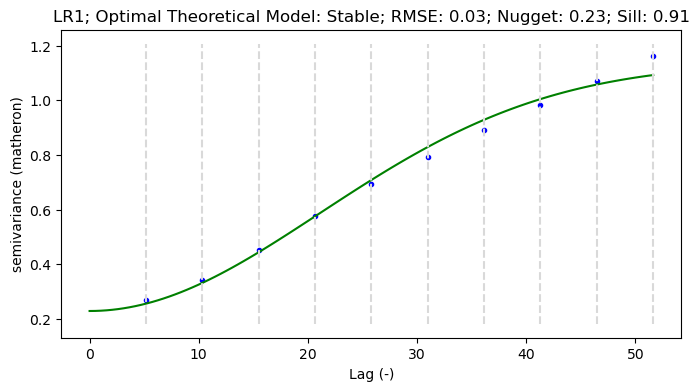

MAE: 0.4084049531076837
RMSE: 0.5138231493579125
MAPE: 2.4976068079847327
R Squared: 0.7532120538847996
Mean of Kriging Var: 0.2448863742748823
Testing Computation Time: 3.06 seconds


In [49]:
eval_combined_array_coordinates = np.array([list(pair) for pair in zip(combined_df['x'], combined_df['y'])])

start_time = time.time()

V_test = skg.Variogram(eval_combined_array_coordinates, combined_df['z'],maxlag='median', 
                       use_nugget = True, fit_method = 'ml', model = 'stable')

OK = skg.OrdinaryKriging(V_test, mode='exact')

 # Predict at test locations
z_pred_test = OK.transform(test_df['x'], test_df['y'])

rmse = np.sqrt(mean_squared_error(test_df['z'], z_pred_test))
mae = mean_absolute_error(test_df['z'], z_pred_test)
mape = mean_absolute_percentage_error(test_df['z'], z_pred_test)
r2 = r2_score(test_df['z'], z_pred_test)
sigma = np.mean(OK.sigma)

end_time = time.time()

fig = V_test.plot(show=False, hist=False)
# After plotting, set the title on the current axes
plt.title(f'LR1; Optimal Theoretical Model: Stable; RMSE: {V_test.rmse:.2f}; Nugget: {V_test.describe()["nugget"]:.2f}; Sill: {V_test.describe()["sill"]:.2f}')
# Now, show the plot
plt.show()

print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape)
print("R Squared:", r2)
print("Mean of Kriging Var:", sigma)
print(f"Testing Computation Time: {end_time - start_time:.2f} seconds")

### Plotting Spatial Interpolation of entire area with Model

In [51]:
filenames = ['cal_LR1_input_randomfield_cal200', 'cal_LR1_input_randomfield_cal400', 'cal_LR1_input_randomfield_cal600', 'cal_LR1_input_randomfield_cal800', 'cal_LR1_input_randomfield_cal1000', 'cal_LR1_input_randomfield_cal1500', 'cal_LR1_input_randomfield_cal2000',
            'val_LR1_input_randomfield_cal2000', 'test_LR1_input_randomfield_cal2000']
#cal_SR0_input_randomfield_cal2000.csv
all_df = pd.DataFrame()
for file in filenames:
    df = pd.read_csv(f'Synthetic Data/LR1/{file}.csv')
    all_df = pd.concat([df, all_df], ignore_index=True)

all_df = all_df.drop_duplicates() #The calibration sets are subsets of one another, hence needed

all_df #All calbration, validation and test data points

,x,y,z
0,83,56,-1.145738
1,40,74,0.359482
2,90,28,-0.532575
3,51,84,-0.525658
4,32,48,-1.727015
...,...,...,...
5995,93,12,0.950197
5996,56,25,0.184283
5997,22,8,-2.189497
5998,38,35,-1.386126


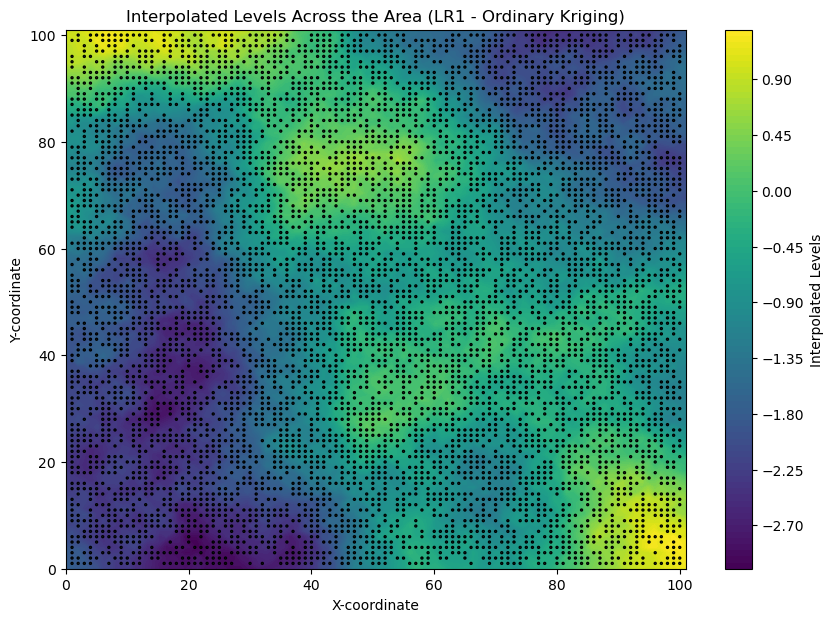

Spatial Interpolation Computation Time: 10.72 seconds


In [53]:
# Using full set: Convert columns to numpy arrays
observed_location_columns = ['x', 'y']
observed_values_column = 'z'
observed_locations = all_df[observed_location_columns].values
observed_values = all_df[observed_values_column].values

# Start timing spatial interpolation
start_time_interpolation = time.time()

# Initialize IDW model
V = skg.Variogram(observed_locations, observed_values,model = 'stable',maxlag='median', use_nugget = True, fit_method = 'ml')
ok = skg.OrdinaryKriging(V, mode='exact')

x_min, x_max = observed_locations[:, 0].min() - 1, observed_locations[:, 0].max() + 1
y_min, y_max = observed_locations[:, 1].min() - 1, observed_locations[:, 1].max() + 1
x_range = np.linspace(x_min, x_max, 100)
y_range = np.linspace(y_min, y_max, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)
grid_points = np.c_[x_grid.ravel(), y_grid.ravel()]

# Interpolate values
interpolated_values = ok.transform(grid_points)
z_grid = interpolated_values.reshape(x_grid.shape)

end_time_interpolation = time.time()  # End timing spatial interpolation

# Visualization
plt.figure(figsize=(10, 7))
plt.contourf(x_grid, y_grid, z_grid, cmap='viridis', levels=100)
plt.colorbar(label='Interpolated Levels')
plt.scatter(all_df['x'], all_df['y'], c=all_df['z'], cmap='viridis', edgecolor='k', label='Observed', s= 2.0)
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
#plt.legend()
plt.title('Interpolated Levels Across the Area (LR1 - Ordinary Kriging)')
plt.show()

print(f"Spatial Interpolation Computation Time: {end_time_interpolation - start_time_interpolation:.2f} seconds")

Spatial Interpolation Computation Time: 5.18 seconds


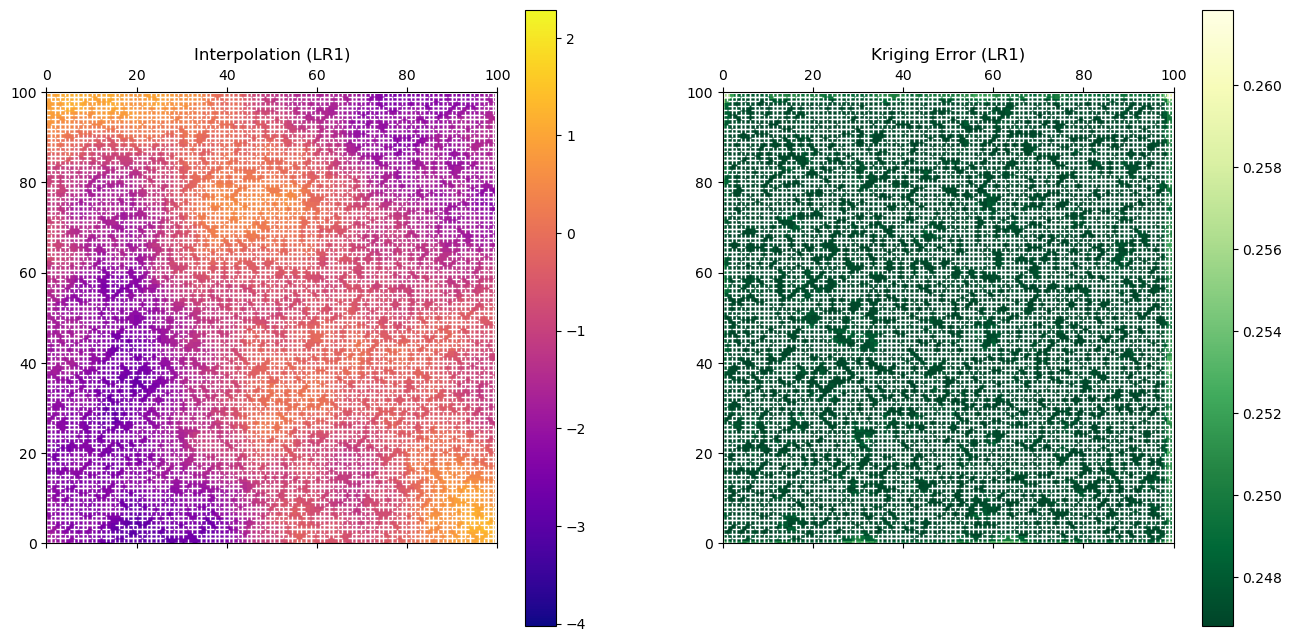

In [54]:
start_time_interpolation = time.time()
ok = skg.OrdinaryKriging(V, mode='exact')
# build the target grid
x = observed_locations[:,0]
y = observed_locations[:,1]
# xx, yy = np.mgrid[0:99:100j, 0:99:100j]
xx, yy = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
s2 = ok.sigma.reshape(xx.shape)

end_time_interpolation = time.time()  # End timing spatial interpolation
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# rescale the coordinates to fit the interpolation raster
x_ = (x - x.min()) / (x.max() - x.min()) * 100
y_ = (y - y.min()) / (y.max() - y.min()) * 100

art = axes[0].matshow(field.T, origin='lower', cmap='plasma', vmin=observed_values.min(), vmax=observed_values.max())
axes[0].set_title('Interpolation (LR1)')
axes[0].plot(x_, y_, '+w')
axes[0].set_xlim((0,100))
axes[0].set_ylim((0,100))
plt.colorbar(art, ax=axes[0])
art = axes[1].matshow(s2.T, origin='lower', cmap='YlGn_r')
axes[1].set_title('Kriging Error (LR1)')
plt.colorbar(art, ax=axes[1])
axes[1].plot(x_, y_, '+w')
axes[1].set_xlim((0,100))
axes[1].set_ylim((0,100));

print(f"Spatial Interpolation Computation Time: {end_time_interpolation - start_time_interpolation:.2f} seconds")